In [20]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, confusion_matrix, classification_report,
    roc_curve, accuracy_score
)

# Background

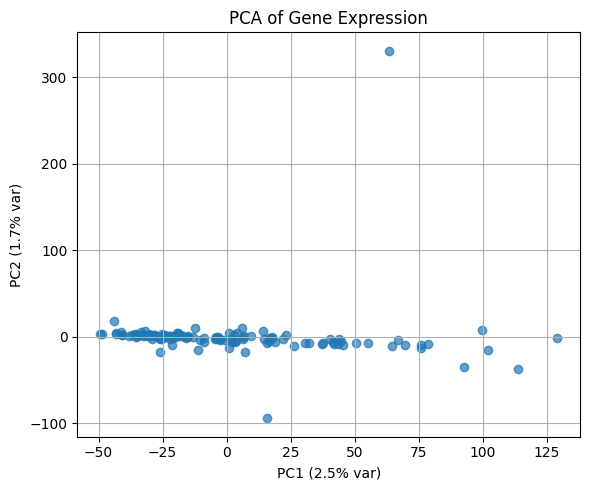

In [166]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

X = tpm_combined.T
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=X.index)
plt.figure(figsize=(6, 5))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Gene Expression")
plt.grid(True)
plt.tight_layout()
plt.show()

# Real data cancer classifier

(60675, 128)
(50519, 128)


Gene set size loop:   7%|███▊                                                      | 1/15 [00:00<00:03,  3.85it/s]

Best gene num: 5


Gene set size loop:  20%|███████████▌                                              | 3/15 [00:01<00:07,  1.71it/s]

Best gene num: 805


Gene set size loop: 100%|█████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.54s/it]


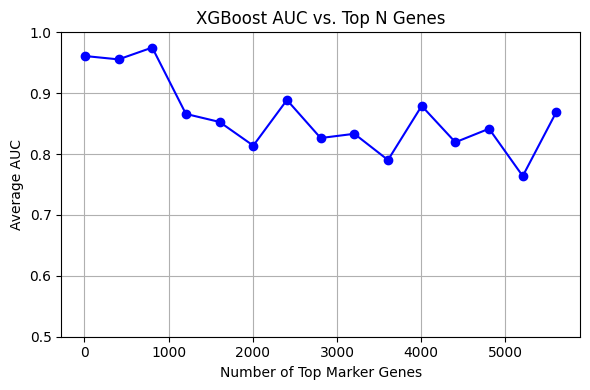

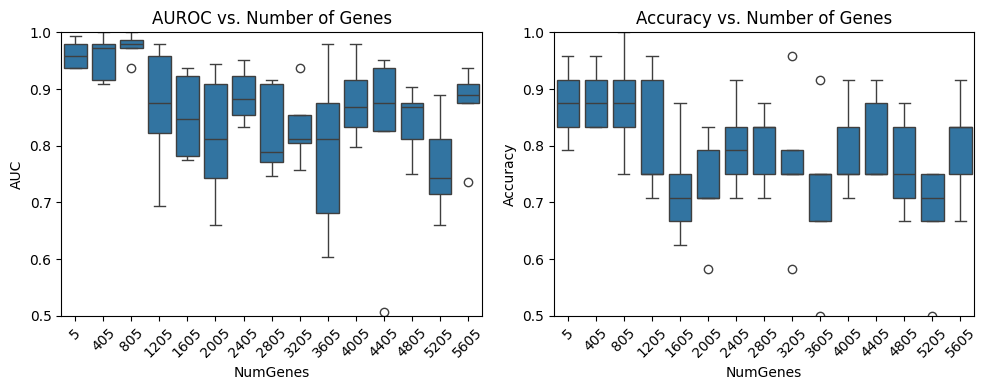

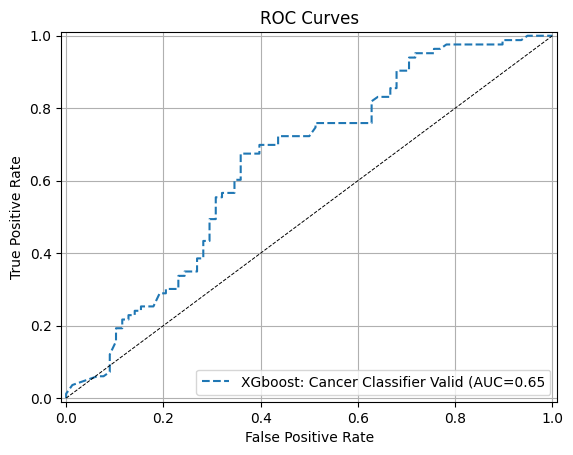

AUC: 0.6486
Accuracy: 0.6398
Precision: 0.6543
Recall: 0.6386
Confusion Matrix:
 [[50 28]
 [30 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63        78
           1       0.65      0.64      0.65        83

    accuracy                           0.64       161
   macro avg       0.64      0.64      0.64       161
weighted avg       0.64      0.64      0.64       161



In [21]:
# Load expression and metadata
tpm_norm = pd.read_csv("data/pnas_normal_tpm.txt", sep='\t')
tpm_norm['gene_id'] = tpm_norm.index
readcounts_norm = pd.read_csv("data/pnas_normal_readcounts.txt", sep='\t')
readcounts_norm['gene_id'] = readcounts_norm.index

# Load expression and metadata
tpm = pd.read_csv("data/pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
readcounts = pd.read_csv("data/pnas_readcounts_96_nodup.txt", sep='\t', header=None)
readcounts.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
patient_info = pd.read_csv("data/pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

# Filter for preselected genes
tpm = tpm.set_index('gene_id')
readcounts_filtered = readcounts.set_index('gene_id')
tpm_norm = tpm_norm.set_index('gene_id')
readcounts_norm = readcounts_norm.set_index('gene_id')

shared_genes = set(readcounts_norm.index) & set(readcounts_filtered.index) & set(tpm.index) & set(tpm_norm.index)

tpm_norm = tpm_norm[tpm_norm.index.isin(shared_genes)]
readcounts_norm = readcounts_norm[readcounts_norm.index.isin(shared_genes)]
tpm = tpm[tpm.index.isin(shared_genes)]
readcounts_filtered = readcounts_filtered[readcounts_filtered.index.isin(shared_genes)]
tpm_combined = pd.concat([tpm_norm, tpm], axis=1)

sample_order = tpm_combined.columns
labels = [0 for i in range(32)] + [1 for i in range(96)]

# rc_df = tpm_combined.T
# rc_df['label'] = labels
# p_values = []
# for gene in rc_df.columns[:-1]:
#     group1 = rc_df[rc_df['label'] == 0][gene]
#     group2 = rc_df[rc_df['label'] == 1][gene]
#     stat, p = ttest_ind(group1, group2, equal_var=False)
#     p_values.append((gene, p))

# with open("genes_p_values.pkl", "wb") as f:
#     pickle.dump(p_values, f)
    
with open("data/genes_p_values.pkl", "rb") as f:
    p_values = pickle.load(f)
    
# Rank genes
ranked_genes = [gene for gene, _ in sorted(p_values, key=lambda x: x[1])]


# Filter low frequency
print(tpm_combined.shape)
max_zero_fraction = 0.9
max_zeros_allowed = int(tpm_combined.shape[1] * max_zero_fraction)
zero_counts = (tpm_combined == 0).sum(axis=1)
tpm_filtered = tpm_combined[zero_counts <= max_zeros_allowed]
print(tpm_filtered.shape)

# Normalize
pseudocount = 1e-6
tpm_logged = tpm_filtered + pseudocount
geometric_means = np.exp(np.log(tpm_logged).mean(axis=1))
ratios = tpm_logged.div(geometric_means, axis=0)
size_factors = ratios.median(axis=0)
tpm_normalized = tpm_combined.div(size_factors, axis=1)

# Training
gene_nums = list(range(5, 6000, 400))
average_aucs = []
all_aucs = {}
all_accs = {}
tpm_df = tpm_normalized.copy()
X_all = tpm_df[sample_order].T

best_genes = None
best_model = None
best_auc = -100
best_acc = None
best_pred = None
for num_genes in tqdm(gene_nums, desc="Gene set size loop"):
    selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))
    X = X_all[selected_genes].copy()
    y = np.array(labels)

    aucs = []
    all_aucs[num_genes] = []
    all_accs[num_genes] = []

    for _ in range(5):
        idx_r = np.where(y == 1)[0]
        idx_n = np.where(y == 0)[0] 
        train_r = np.random.choice(idx_r, 20, replace=False) 
        train_n = np.random.choice(idx_n, 20, replace=False)
        test_r = np.setdiff1d(idx_r, train_r) 
        test_n = np.setdiff1d(idx_n, train_n)

        test_r = np.random.choice(test_r, 12, replace=False) 
        test_n = np.random.choice(test_n, 12, replace=False)

        train_idx = np.concatenate([train_r, train_n])
        test_idx = np.concatenate([test_r, test_n])

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        non_zero_cols = (X_train != 0).any(axis=0)
        X_train = X_train.loc[:, non_zero_cols]
        X_test = X_test.loc[:, non_zero_cols]

        model = xgb.XGBClassifier(eval_metric='logloss')
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        auc = roc_auc_score(y_test, y_pred_prob)
        all_aucs[num_genes].append(auc)
        all_accs[num_genes].append(accuracy)
        aucs.append(auc)

    current_auc = np.mean(aucs)
    if current_auc > best_auc:
        best_pred = y_pred
        best_acc = accuracy
        best_auc = current_auc
        best_model = model
        best_genes = selected_genes
        print("Best gene num:", num_genes)
    average_aucs.append(np.mean(aucs))
    
plt.figure(figsize=(6, 4))
plt.plot(gene_nums, average_aucs, marker='o', color='blue')
plt.title("XGBoost AUC vs. Top N Genes")
plt.xlabel("Number of Top Marker Genes")
plt.ylabel("Average AUC")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot boxplot of AUROC and accuracy
df_auc = pd.DataFrame([
    {'NumGenes': k, 'AUC': v} for k, auc_list in all_aucs.items() for v in auc_list
])
df_acc = pd.DataFrame([
    {'NumGenes': k, 'Accuracy': v} for k, acc_list in all_accs.items() for v in acc_list
])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_auc, x='NumGenes', y='AUC')
plt.ylim(0.5, 1.0)
plt.title("AUROC vs. Number of Genes")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_acc, x='NumGenes', y='Accuracy')
plt.ylim(0.5, 1.0)
plt.title("Accuracy vs. Number of Genes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Validation dataset test
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
# tpm_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm_valid.shape[1])]
# readcounts_valid = pd.read_csv("data/validation_exon_readcounts", sep='\t')
# readcounts_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, readcounts_valid.shape[1])]

tpm_valid_df = tpm_valid.T
tpm_valid_df['label'] = tpm_valid_df.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)
valid_labels = tpm_valid_df['label']
valid_X_filtered = tpm_valid_df[best_model.get_booster().feature_names]
y_pred_prob = best_model.predict_proba(valid_X_filtered)[:, 1]

fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob)
auc_valid = roc_auc_score(valid_labels, y_pred_prob)
plt.plot(
    fpr,
    tpr,
    linestyle="--",
    label=f"XGboost: Cancer Classifier Valid (AUC={auc_valid:.2f}"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=0.7)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

y_pred = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(valid_labels, y_pred_prob)
accuracy = accuracy_score(valid_labels, y_pred)
precision = precision_score(valid_labels, y_pred)
recall = recall_score(valid_labels, y_pred)
conf_matrix = confusion_matrix(valid_labels, y_pred)
report = classification_report(valid_labels, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Gene set size loop:   7%|████████                                                                                                                | 1/15 [00:00<00:03,  3.92it/s]

Best gene num: 5


Gene set size loop:  13%|████████████████                                                                                                        | 2/15 [00:00<00:05,  2.55it/s]

Best gene num: 405


Gene set size loop:  27%|████████████████████████████████                                                                                        | 4/15 [00:02<00:08,  1.24it/s]

Best gene num: 1205


Gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.56s/it]


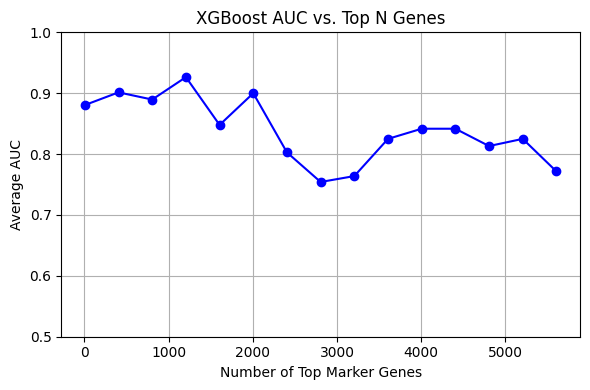

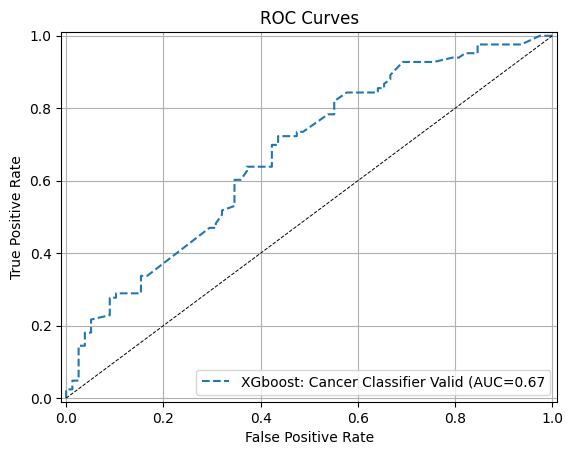

AUC: 0.6735
Accuracy: 0.6211
Precision: 0.6310
Recall: 0.6386
Confusion Matrix:
 [[47 31]
 [30 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61        78
           1       0.63      0.64      0.63        83

    accuracy                           0.62       161
   macro avg       0.62      0.62      0.62       161
weighted avg       0.62      0.62      0.62       161



In [14]:
gene_nums = list(range(5, 6000, 400))
average_aucs = []
tpm_df = tpm_normalized.copy()
X_all = tpm_df[sample_order].T

best_genes = None
best_model = None
best_auc = -100
best_acc = None
best_pred = None
for num_genes in tqdm(gene_nums, desc="Gene set size loop"):
    selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))
    X = X_all[selected_genes].copy()
    y = np.array(labels)

    aucs = []
    for _ in range(5):
        idx_r = np.where(y == 1)[0]
        idx_n = np.where(y == 0)[0] 
        train_r = np.random.choice(idx_r, 20, replace=False) 
        train_n = np.random.choice(idx_n, 20, replace=False)
        test_r = np.setdiff1d(idx_r, train_r) 
        test_n = np.setdiff1d(idx_n, train_n)

        test_r = np.random.choice(test_r, 12, replace=False) 
        test_n = np.random.choice(test_n, 12, replace=False)

        train_idx = np.concatenate([train_r, train_n])
        test_idx = np.concatenate([test_r, test_n])

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        non_zero_cols = (X_train != 0).any(axis=0)
        X_train = X_train.loc[:, non_zero_cols]
        X_test = X_test.loc[:, non_zero_cols]

        model = xgb.XGBClassifier(eval_metric='logloss')
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        aucs.append(roc_auc_score(y_test, y_pred_prob))

    current_auc = np.mean(aucs)
    if current_auc > best_auc:
        best_pred = y_pred
        best_acc = accuracy
        best_auc = current_auc
        best_model = model
        best_genes = selected_genes
        print("Best gene num:", num_genes)
    average_aucs.append(np.mean(aucs))
    
plt.figure(figsize=(6, 4))
plt.plot(gene_nums, average_aucs, marker='o', color='blue')
plt.title("XGBoost AUC vs. Top N Genes")
plt.xlabel("Number of Top Marker Genes")
plt.ylabel("Average AUC")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation dataset test
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
# tpm_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm_valid.shape[1])]
# readcounts_valid = pd.read_csv("data/validation_exon_readcounts", sep='\t')
# readcounts_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, readcounts_valid.shape[1])]

tpm_valid_df = tpm_valid.T
tpm_valid_df['label'] = tpm_valid_df.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)
valid_labels = tpm_valid_df['label']
valid_X_filtered = tpm_valid_df[best_model.get_booster().feature_names]
y_pred_prob = best_model.predict_proba(valid_X_filtered)[:, 1]

fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob)
auc_valid = roc_auc_score(valid_labels, y_pred_prob)
plt.plot(
    fpr,
    tpr,
    linestyle="--",
    label=f"XGboost: Cancer Classifier Valid (AUC={auc_valid:.2f}"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=0.7)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

y_pred = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(valid_labels, y_pred_prob)
accuracy = accuracy_score(valid_labels, y_pred)
precision = precision_score(valid_labels, y_pred)
recall = recall_score(valid_labels, y_pred)
conf_matrix = confusion_matrix(valid_labels, y_pred)
report = classification_report(valid_labels, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# cancer classifier Validation

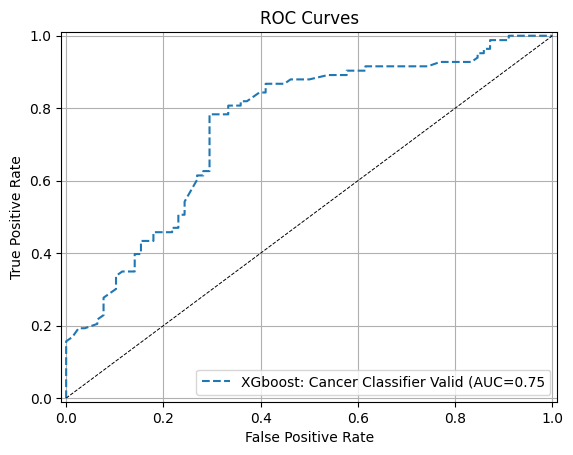

AUC: 0.7522
Accuracy: 0.7143
Precision: 0.6697
Recall: 0.8795
Confusion Matrix:
 [[42 36]
 [10 73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        78
           1       0.67      0.88      0.76        83

    accuracy                           0.71       161
   macro avg       0.74      0.71      0.70       161
weighted avg       0.74      0.71      0.71       161



In [12]:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
# tpm_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm_valid.shape[1])]
# readcounts_valid = pd.read_csv("data/validation_exon_readcounts", sep='\t')
# readcounts_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, readcounts_valid.shape[1])]

tpm_valid_df = tpm_valid.T
tpm_valid_df['label'] = tpm_valid_df.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)
valid_labels = tpm_valid_df['label']
valid_X_filtered = tpm_valid_df[best_model.get_booster().feature_names]
y_pred_prob = best_model.predict_proba(valid_X_filtered)[:, 1]

fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob)
auc_valid = roc_auc_score(valid_labels, y_pred_prob)
plt.plot(
    fpr,
    tpr,
    linestyle="--",
    label=f"XGboost: Cancer Classifier Valid (AUC={auc_valid:.2f}"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=0.7)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

y_pred = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(valid_labels, y_pred_prob)
accuracy = accuracy_score(valid_labels, y_pred)
precision = precision_score(valid_labels, y_pred)
recall = recall_score(valid_labels, y_pred)
conf_matrix = confusion_matrix(valid_labels, y_pred)
report = classification_report(valid_labels, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# recurrence classifier

In [145]:
# Load expression and metadata
tpm = pd.read_csv("data/pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
readcounts = pd.read_csv("data/pnas_readcounts_96_nodup.txt", sep='\t', header=None)
readcounts.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
patient_info = pd.read_csv("data/pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

# Filter for preselected genes
tpm = tpm.set_index('gene_id')
readcounts_filtered = readcounts.set_index('gene_id')
tpm_combined = tpm.copy()

sample_order = tpm_combined.columns
labels = patient_info['recurStatus'].map({'N': 0, 'R': 1}).values

In [146]:
# rc_df = tpm_combined.T
# rc_df['label'] = labels
# p_values = []
# for gene in rc_df.columns[:-1]:
#     group1 = rc_df[rc_df['label'] == 0][gene]
#     group2 = rc_df[rc_df['label'] == 1][gene]
#     stat, p = ttest_ind(group1, group2, equal_var=False)
#     p_values.append((gene, p))

# with open("data/recurrence_genes_p_values.pkl", "wb") as f:
#     pickle.dump(p_values, f)
    
with open("data/recurrence_genes_p_values.pkl", "rb") as f:
    p_values = pickle.load(f)
    
# Rank genes
ranked_genes = [gene for gene, _ in sorted(p_values, key=lambda x: x[1])]

In [147]:
tpm_combined.shape

(60675, 96)

In [150]:
max_zero_fraction = 0.8
max_zeros_allowed = int(tpm_combined.shape[1] * max_zero_fraction)
zero_counts = (tpm_combined == 0).sum(axis=1)
tpm_filtered = tpm_combined[zero_counts <= max_zeros_allowed]

In [151]:
tpm_filtered.shape

(42551, 96)

In [152]:
# pseudocount = 1e-6
# tpm_logged = tpm_filtered + pseudocount
# geometric_means = np.exp(np.log(tpm_logged).mean(axis=1))
# ratios = tpm_logged.div(geometric_means, axis=0)
# size_factors = ratios.median(axis=0)
# tpm_normalized = tpm_combined.div(size_factors, axis=1)

tpm_df = tpm_filtered.copy()
X_all = tpm_df[sample_order].T

Gene set size loop:   3%|███▍                                                                                                                    | 1/35 [00:00<00:09,  3.63it/s]

Best gene num: 5


Gene set size loop:   6%|██████▊                                                                                                                 | 2/35 [00:00<00:09,  3.52it/s]

Best gene num: 205


Gene set size loop:   9%|██████████▎                                                                                                             | 3/35 [00:01<00:12,  2.59it/s]

Best gene num: 405


Gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [01:40<00:00,  2.88s/it]


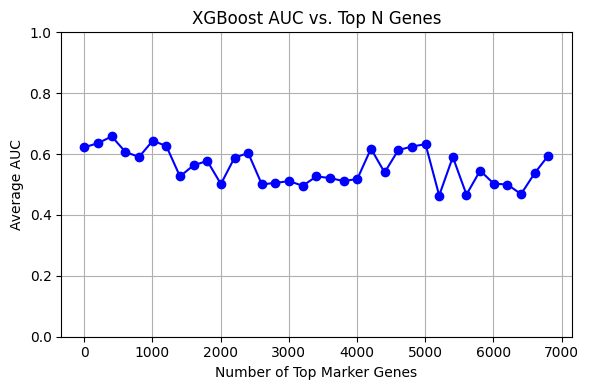

In [153]:
best_genes = None
best_model = None
best_auc = -100

gene_nums = list(range(5, 7000, 200))
average_aucs = []

for num_genes in tqdm(gene_nums, desc="Gene set size loop"):
    selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))
    X = X_all[selected_genes].copy()
    y = labels.copy()

    aucs = []
    for _ in range(5):
        idx_r = np.where(y == 1)[0]
        idx_n = np.where(y == 0)[0]
        train_r = np.random.choice(idx_r, 15, replace=False)
        train_n = np.random.choice(idx_n, 15, replace=False)
        test_r = np.setdiff1d(idx_r, train_r)
        test_n = np.setdiff1d(idx_n, train_n)
        test_r = np.random.choice(test_r, 13, replace=False)
        test_n = np.random.choice(test_n, 13, replace=False)

        train_idx = np.concatenate([train_r, train_n])
        test_idx = np.concatenate([test_r, test_n])

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        non_zero_cols = (X_train != 0).any(axis=0)
        X_train = X_train.loc[:, non_zero_cols]
        X_test = X_test.loc[:, non_zero_cols]

        model = xgb.XGBClassifier(eval_metric='logloss')
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        aucs.append(roc_auc_score(y_test, y_pred_prob))
    
    current_auc = np.mean(aucs)
    if current_auc > best_auc:
        best_auc = current_auc
        best_model = model
        best_genes = selected_genes
        print("Best gene num:", num_genes)
    average_aucs.append(np.mean(aucs))

plt.figure(figsize=(6, 4))
plt.plot(gene_nums, average_aucs, marker='o', color='blue')
plt.title("XGBoost AUC vs. Top N Genes")
plt.xlabel("Number of Top Marker Genes")
plt.ylabel("Average AUC")
plt.ylim(0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

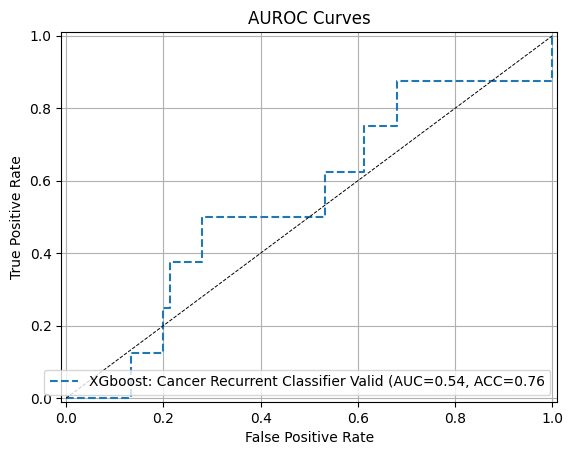

AUC: 0.5433
Accuracy: 0.7590
Precision: 0.0714
Recall: 0.1250
Confusion Matrix:
 [[62 13]
 [ 7  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86        75
           1       0.07      0.12      0.09         8

    accuracy                           0.76        83
   macro avg       0.48      0.48      0.48        83
weighted avg       0.82      0.76      0.79        83



In [156]:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
tpm_valid = tpm_valid[cancer_patients]

tpm_df = tpm_valid.T
tpm_df = tpm_df.sort_index()
sort_patients = tpm_df.index
sort_patients = tpm_df.index
label_map = valid_cancer_patient.set_index('Mapping ID')[
    'Recurrence Staus at the time of collection'
].map({'Nonrecurrent': 0, 'Recurrent': 1})
valid_labels = tpm_df.index.to_series().map(label_map).values

valid_X_filtered = tpm_df[best_model.get_booster().feature_names]
valid_X_filtered = valid_X_filtered.sort_index()
y_pred_prob = best_model.predict_proba(valid_X_filtered)[:, 1]
y_pred = best_model.predict(valid_X_filtered)
fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob)
auc_valid = roc_auc_score(valid_labels, y_pred_prob)
acc_valid = accuracy_score(valid_labels, y_pred)
plt.plot(
    fpr,
    tpr,
    linestyle="--",
    label=f"XGboost: Cancer Recurrent Classifier Valid (AUC={auc_valid:.2f}, ACC={acc_valid:.2f}"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=0.7)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"AUROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


auc = roc_auc_score(valid_labels, y_pred_prob)
accuracy = accuracy_score(valid_labels, y_pred)
precision = precision_score(valid_labels, y_pred)
recall = recall_score(valid_labels, y_pred)
conf_matrix = confusion_matrix(valid_labels, y_pred)
report = classification_report(valid_labels, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

In [17]:
# best_model.get_booster().feature_names